In [24]:
import glob
import numpy as np
import netCDF4 as nc
from scipy.ndimage import binary_dilation
nt=0
nt_warm=0
#print(files)
bin2L=[]
f_old=[]
import os
import pyresample
tb_L=[]
sfc_precip_L=[]
from pykdtree.kdtree import KDTree
import pickle
ntot=0
for im in [2,5,8,11]:
    files=sorted(glob.glob('1C_GMI/2017/%2.2i/*'%im))
    for f in files[:]:
        with nc.Dataset(f) as fh:
            vars=fh.variables.keys()
        #print(vars)
            if 'bin_nodes_corra' not in vars:
                f_old.append(f)
                os.system('rm %s'%f)
                continue
            lon_s1=fh.variables["Longitude_S1"][:]
            lat_s1=fh.variables["Latitude_S1"][:]
            tb_s1=fh.variables["Tb_S1"][:]
            lat_dpr=fh.variables["Latitude_DPR"][:]
            lon_dpr=fh.variables["Longitude_DPR"][:]
            
            land_sea_type=fh['surface_type_corra'][:]
            bin_nodes=fh['bin_nodes_corra'][:]
            precip_type=fh['precip_type_corra'][:]
            grid_def = pyresample.geometry.GridDefinition(lons=lon_dpr.data, lats=lat_dpr.data)
            swath_def = pyresample.geometry.SwathDefinition(lons=lon_s1.data, lats=lat_s1.data)
            tb_s1_resampled = pyresample.kd_tree.resample_gauss(swath_def, tb_s1[:,:,:].data, grid_def, radius_of_influence=50000, fill_value=None, sigmas=[25000 for k in range(9)])
            no_sea_mask=binary_dilation(land_sea_type!=0,iterations=5)
            #stop
            near_surf_precip=fh.variables["near_sfc_rain_corra"][:]
            Latitude_CSAT=fh.variables["Latitude_CSAT"][:]
            Longitude_CSAT=fh.variables["Longitude_CSAT"][:]
            precip_csat=fh.variables["precip_csat"][:]
            loc_dpr=np.array([lon_dpr.flatten(),lat_dpr.flatten()]).T
            loc_csat=np.array([Longitude_CSAT.flatten(),Latitude_CSAT.flatten()]).T
            kdt = KDTree(loc_dpr,leafsize=10)
            dist,indx=kdt.query(loc_csat,1)
            a_dist=np.nonzero(dist<0.02)
        d_collocated={}
        for ind1 in a_dist[0]:
            i_dpr=indx[ind1]//lon_dpr.shape[1]
            j_dpr=indx[ind1]%lon_dpr.shape[1]
            if no_sea_mask[i_dpr,j_dpr]!=0:
                continue
            if (i_dpr,j_dpr) not in d_collocated:
                d_collocated[(i_dpr,j_dpr)]=[[precip_csat[ind1]],[near_surf_precip[i_dpr,j_dpr],tb_s1_resampled[i_dpr,j_dpr,:].data,precip_type[i_dpr,j_dpr]]]
            else:
                d_collocated[(i_dpr,j_dpr)][0].append(precip_csat[ind1])  
        fout='pickle_dir/colloc_data.'+f[37:-9]+'pklz'
        ntot+=len(d_collocated)
        if len(d_collocated)==0:
            continue
        pickle.dump(d_collocated,open(fout,'wb'))



/Users/mgrecu/miniforge3/lib/python3.10/site-packages/pyresample/kd_tree.py:261: UserWarning: Possible more than 8 neighbours within 50000 m for some data points
  get_neighbour_info(source_geo_def,


In [25]:
print(ntot)

11287


In [15]:
import 
#print(len(d_collocated))

38


In [22]:
print(f[37:-9])

20170201-S110037-E123311.016644.


In [70]:
sfc_precip_L=np.array(sfc_precip_L)
a=np.nonzero(sfc_precip_L>0)
print(len(a[0])/sfc_precip_L.size)

import xarray as xr
tbx=xr.DataArray(np.array(tb_L),dims=['nt','nch'],name='tb').astype('float32')
sfc_precip_x=xr.DataArray(sfc_precip_L,dims=['nt'],name='sfc_precip').astype('float32')
complev=5
encoding={'tb': {'complevel': complev, 'zlib': True},'sfc_precip': {'complevel': complev, 'zlib': True}}
ds=xr.Dataset({'tb':tbx,'sfc_precip':sfc_precip_x})
ds.to_netcdf('tb_sfc_precip_2017_1_4_7_10.nc',encoding=encoding)


0.05347632718650787


18804763 0 0.0


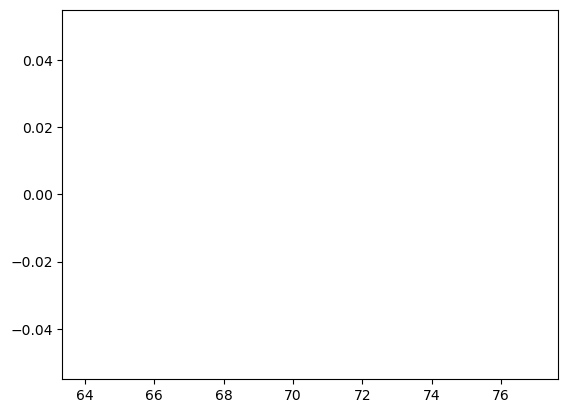

In [52]:
print(nt,nt_warm,nt_warm/nt*100)
import matplotlib.pyplot as plt
h1=plt.hist(bin2L,bins=np.arange(64,78))

In [7]:
print(len(a[0]))

0
